# **문자 언어 모델링**

- RNN으로 더 매력적인 문제를 풀어봅시다.
> RNN은 LSTM, GRU(Gated Recurrent Unit)와 같은 다양한 파생형이 있다.
>
>셰익스피어의 작품의로 이루어진 데이터셋을 이용해 학샙을 수행해보자. 이 모델은 자신에게 제공된 선행 문자 뒤에 어떤 문자가 올지 예측하도록 학습해야 한다.

In [0]:
import numpy as np

class Tensor (object):
    
    def __init__(self,data,
                 autograd=False,
                 creators=None,
                 creation_op=None,
                 id=None):
        
        self.data = np.array(data)
        self.autograd = autograd
        self.grad = None

        if(id is None):
            self.id = np.random.randint(0,1000000000)
        else:
            self.id = id
        
        self.creators = creators
        self.creation_op = creation_op
        self.children = {}
        
        if(creators is not None):
            for c in creators:
                if(self.id not in c.children):
                    c.children[self.id] = 1
                else:
                    c.children[self.id] += 1

    def all_children_grads_accounted_for(self):
        for id,cnt in self.children.items():
            if(cnt != 0):
                return False
        return True 
        
    def backward(self,grad=None, grad_origin=None):
        if(self.autograd):
 
            if(grad is None):
                grad = Tensor(np.ones_like(self.data))

            if(grad_origin is not None):
                if(self.children[grad_origin.id] == 0):
                    return
                    print(self.id)
                    print(self.creation_op)
                    print(len(self.creators))
                    for c in self.creators:
                        print(c.creation_op)
                    raise Exception("cannot backprop more than once")
                else:
                    self.children[grad_origin.id] -= 1

            if(self.grad is None):
                self.grad = grad
            else:
                self.grad += grad
            
            # grads must not have grads of their own
            assert grad.autograd == False
            
            # only continue backpropping if there's something to
            # backprop into and if all gradients (from children)
            # are accounted for override waiting for children if
            # "backprop" was called on this variable directly
            if(self.creators is not None and 
               (self.all_children_grads_accounted_for() or 
                grad_origin is None)):

                if(self.creation_op == "add"):
                    self.creators[0].backward(self.grad, self)
                    self.creators[1].backward(self.grad, self)
                    
                if(self.creation_op == "sub"):
                    self.creators[0].backward(Tensor(self.grad.data), self)
                    self.creators[1].backward(Tensor(self.grad.__neg__().data), self)

                if(self.creation_op == "mul"):
                    new = self.grad * self.creators[1]
                    self.creators[0].backward(new , self)
                    new = self.grad * self.creators[0]
                    self.creators[1].backward(new, self)                    
                    
                if(self.creation_op == "mm"):
                    c0 = self.creators[0]
                    c1 = self.creators[1]
                    new = self.grad.mm(c1.transpose())
                    c0.backward(new)
                    new = self.grad.transpose().mm(c0).transpose()
                    c1.backward(new)
                    
                if(self.creation_op == "transpose"):
                    self.creators[0].backward(self.grad.transpose())

                if("sum" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.expand(dim,
                                                               self.creators[0].data.shape[dim]))

                if("expand" in self.creation_op):
                    dim = int(self.creation_op.split("_")[1])
                    self.creators[0].backward(self.grad.sum(dim))
                    
                if(self.creation_op == "neg"):
                    self.creators[0].backward(self.grad.__neg__())
                    
                if(self.creation_op == "sigmoid"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (self * (ones - self)))
                
                if(self.creation_op == "tanh"):
                    ones = Tensor(np.ones_like(self.grad.data))
                    self.creators[0].backward(self.grad * (ones - (self * self)))
                
                if(self.creation_op == "index_select"):
                    new_grad = np.zeros_like(self.creators[0].data)
                    indices_ = self.index_select_indices.data.flatten()
                    grad_ = grad.data.reshape(len(indices_), -1)
                    for i in range(len(indices_)):
                        new_grad[indices_[i]] += grad_[i]
                    self.creators[0].backward(Tensor(new_grad))
                    
                if(self.creation_op == "cross_entropy"):
                    dx = self.softmax_output - self.target_dist
                    self.creators[0].backward(Tensor(dx))
                    
    def __add__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data + other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="add")
        return Tensor(self.data + other.data)

    def __neg__(self):
        if(self.autograd):
            return Tensor(self.data * -1,
                          autograd=True,
                          creators=[self],
                          creation_op="neg")
        return Tensor(self.data * -1)
    
    def __sub__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data - other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="sub")
        return Tensor(self.data - other.data)
    
    def __mul__(self, other):
        if(self.autograd and other.autograd):
            return Tensor(self.data * other.data,
                          autograd=True,
                          creators=[self,other],
                          creation_op="mul")
        return Tensor(self.data * other.data)    

    def sum(self, dim):
        if(self.autograd):
            return Tensor(self.data.sum(dim),
                          autograd=True,
                          creators=[self],
                          creation_op="sum_"+str(dim))
        return Tensor(self.data.sum(dim))
    
    def expand(self, dim,copies):

        trans_cmd = list(range(0,len(self.data.shape)))
        trans_cmd.insert(dim,len(self.data.shape))
        new_data = self.data.repeat(copies).reshape(list(self.data.shape) + [copies]).transpose(trans_cmd)
        
        if(self.autograd):
            return Tensor(new_data,
                          autograd=True,
                          creators=[self],
                          creation_op="expand_"+str(dim))
        return Tensor(new_data)
    
    def transpose(self):
        if(self.autograd):
            return Tensor(self.data.transpose(),
                          autograd=True,
                          creators=[self],
                          creation_op="transpose")
        
        return Tensor(self.data.transpose())
    
    def mm(self, x):
        if(self.autograd):
            return Tensor(self.data.dot(x.data),
                          autograd=True,
                          creators=[self,x],
                          creation_op="mm")
        return Tensor(self.data.dot(x.data))
    
    def sigmoid(self):
        if(self.autograd):
            return Tensor(1 / (1 + np.exp(-self.data)),
                          autograd=True,
                          creators=[self],
                          creation_op="sigmoid")
        return Tensor(1 / (1 + np.exp(-self.data)))

    def tanh(self):
        if(self.autograd):
            return Tensor(np.tanh(self.data),
                          autograd=True,
                          creators=[self],
                          creation_op="tanh")
        return Tensor(np.tanh(self.data))
    
    def index_select(self, indices):

        if(self.autograd):
            new = Tensor(self.data[indices.data],
                         autograd=True,
                         creators=[self],
                         creation_op="index_select")
            new.index_select_indices = indices
            return new
        return Tensor(self.data[indices.data])
    
    def softmax(self):
        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        return softmax_output
    
    def cross_entropy(self, target_indices):

        temp = np.exp(self.data)
        softmax_output = temp / np.sum(temp,
                                       axis=len(self.data.shape)-1,
                                       keepdims=True)
        
        t = target_indices.data.flatten()
        p = softmax_output.reshape(len(t),-1)
        target_dist = np.eye(p.shape[1])[t]
        loss = -(np.log(p) * (target_dist)).sum(1).mean()
    
        if(self.autograd):
            out = Tensor(loss,
                         autograd=True,
                         creators=[self],
                         creation_op="cross_entropy")
            out.softmax_output = softmax_output
            out.target_dist = target_dist
            return out

        return Tensor(loss)
        
    
    def __repr__(self):
        return str(self.data.__repr__())
    
    def __str__(self):
        return str(self.data.__str__())  

class Layer(object):
    
    def __init__(self):
        self.parameters = list()
        
    def get_parameters(self):
        return self.parameters

    
class SGD(object):
    
    def __init__(self, parameters, alpha=0.1):
        self.parameters = parameters
        self.alpha = alpha
    
    def zero(self):
        for p in self.parameters:
            p.grad.data *= 0
        
    def step(self, zero=True):
        
        for p in self.parameters:
            
            p.data -= p.grad.data * self.alpha
            
            if(zero):
                p.grad.data *= 0


class Linear(Layer):

    def __init__(self, n_inputs, n_outputs, bias=True):
        super().__init__()
        
        self.use_bias = bias
        
        W = np.random.randn(n_inputs, n_outputs) * np.sqrt(2.0/(n_inputs))
        self.weight = Tensor(W, autograd=True)
        if(self.use_bias):
            self.bias = Tensor(np.zeros(n_outputs), autograd=True)
        
        self.parameters.append(self.weight)
        
        if(self.use_bias):        
            self.parameters.append(self.bias)

    def forward(self, input):
        if(self.use_bias):
            return input.mm(self.weight)+self.bias.expand(0,len(input.data))
        return input.mm(self.weight)


class Sequential(Layer):
    
    def __init__(self, layers=list()):
        super().__init__()
        
        self.layers = layers
    
    def add(self, layer):
        self.layers.append(layer)
        
    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input
    
    def get_parameters(self):
        params = list()
        for l in self.layers:
            params += l.get_parameters()
        return params


class Embedding(Layer):
    
    def __init__(self, vocab_size, dim):
        super().__init__()
        
        self.vocab_size = vocab_size
        self.dim = dim
        
        # this random initialiation style is just a convention from word2vec
        self.weight = Tensor((np.random.rand(vocab_size, dim) - 0.5) / dim, autograd=True)
        
        self.parameters.append(self.weight)
    
    def forward(self, input):
        return self.weight.index_select(input)


class Tanh(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.tanh()


class Sigmoid(Layer):
    def __init__(self):
        super().__init__()
    
    def forward(self, input):
        return input.sigmoid()
    

class CrossEntropyLoss(object):
    
    def __init__(self):
        super().__init__()
    
    def forward(self, input, target):
        return input.cross_entropy(target)

    
class RNNCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output, activation='sigmoid'):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output
        
        if(activation == 'sigmoid'):
            self.activation = Sigmoid()
        elif(activation == 'tanh'):
            self.activation == Tanh()
        else:
            raise Exception("Non-linearity not found")

        self.w_ih = Linear(n_inputs, n_hidden)
        self.w_hh = Linear(n_hidden, n_hidden)
        self.w_ho = Linear(n_hidden, n_output)
        
        self.parameters += self.w_ih.get_parameters()
        self.parameters += self.w_hh.get_parameters()
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        from_prev_hidden = self.w_hh.forward(hidden)
        combined = self.w_ih.forward(input) + from_prev_hidden
        new_hidden = self.activation.forward(combined)
        output = self.w_ho.forward(new_hidden)
        return output, new_hidden
    
    def init_hidden(self, batch_size=1):
        return Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
    
class LSTMCell(Layer):
    
    def __init__(self, n_inputs, n_hidden, n_output):
        super().__init__()

        self.n_inputs = n_inputs
        self.n_hidden = n_hidden
        self.n_output = n_output

        self.xf = Linear(n_inputs, n_hidden)
        self.xi = Linear(n_inputs, n_hidden)
        self.xo = Linear(n_inputs, n_hidden)        
        self.xc = Linear(n_inputs, n_hidden)        
        
        self.hf = Linear(n_hidden, n_hidden, bias=False)
        self.hi = Linear(n_hidden, n_hidden, bias=False)
        self.ho = Linear(n_hidden, n_hidden, bias=False)
        self.hc = Linear(n_hidden, n_hidden, bias=False)        
        
        self.w_ho = Linear(n_hidden, n_output, bias=False)
        
        self.parameters += self.xf.get_parameters()
        self.parameters += self.xi.get_parameters()
        self.parameters += self.xo.get_parameters()
        self.parameters += self.xc.get_parameters()

        self.parameters += self.hf.get_parameters()
        self.parameters += self.hi.get_parameters()        
        self.parameters += self.ho.get_parameters()        
        self.parameters += self.hc.get_parameters()                
        
        self.parameters += self.w_ho.get_parameters()        
    
    def forward(self, input, hidden):
        
        prev_hidden = hidden[0]        
        prev_cell = hidden[1]
        
        f = (self.xf.forward(input) + self.hf.forward(prev_hidden)).sigmoid()
        i = (self.xi.forward(input) + self.hi.forward(prev_hidden)).sigmoid()
        o = (self.xo.forward(input) + self.ho.forward(prev_hidden)).sigmoid()        
        g = (self.xc.forward(input) + self.hc.forward(prev_hidden)).tanh()        
        c = (f * prev_cell) + (i * g)

        h = o * c.tanh()
        
        output = self.w_ho.forward(h)
        return output, (h, c)
    
    def init_hidden(self, batch_size=1):
        init_hidden = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_cell = Tensor(np.zeros((batch_size,self.n_hidden)), autograd=True)
        init_hidden.data[:,0] += 1
        init_cell.data[:,0] += 1
        return (init_hidden, init_cell)

In [0]:
import sys,random,math
from collections import Counter
import numpy as np
import sys

np.random.seed(0)

f = open('shakespear.txt','r')
raw = f.read()
f.close()

vocab = list(set(raw))
word2index = {}
for i,word in enumerate(vocab):
    word2index[word]=i
indices = np.array(list(map(lambda x:word2index[x], raw)))

앞선 단원에서는 데이터 안에 있는 단어를 이용해 어휘를 만들었다면 이번에는 데이터셋 안의 문자(글자 하나)를 이용해서 만들어 진다. 그렇기 때문에 데이터셋 또한 단어가 아닌 문자에 상응하는 인덱스 리스트로 변환된다. NumPy 배열인 indices가 바로 그 리스트다.
> 다음은 RNN 기본 코드로 이코드는 차원수를 8로 RNN 은닉 계층의 크기를 512로 해서 임베딩을 초기화하며, 출력 가중치는 0으로 초기화 하며 마지막으로 교차 엔트로피 손실 함수(`CrossEntrypyLoss()`)와 확률적 경사하강법 최적화기(`SGD`)를 초기화하는 코드이다. 

In [0]:
embed = Embedding(vocab_size=len(vocab),dim=512)
model = LSTMCell(n_inputs=512, n_hidden=512, n_output=len(vocab))
model.w_ho.weight.data *= 0

criterion = CrossEntropyLoss()
optim = SGD(parameters=model.get_parameters() + embed.get_parameters(), alpha=0.05)

# **부분 역전파의 필요성**

- 문자 100,000개는 역전파하기 어렵습니다.
> RNN 코드에서 가장 어려운 부분 중 하나는 바로 데이터를 공급하는 **미니 배치 논리**이다. 앞에서 만들었던 신경망들은 내장 for 반복문으로 이를 시행했었다.

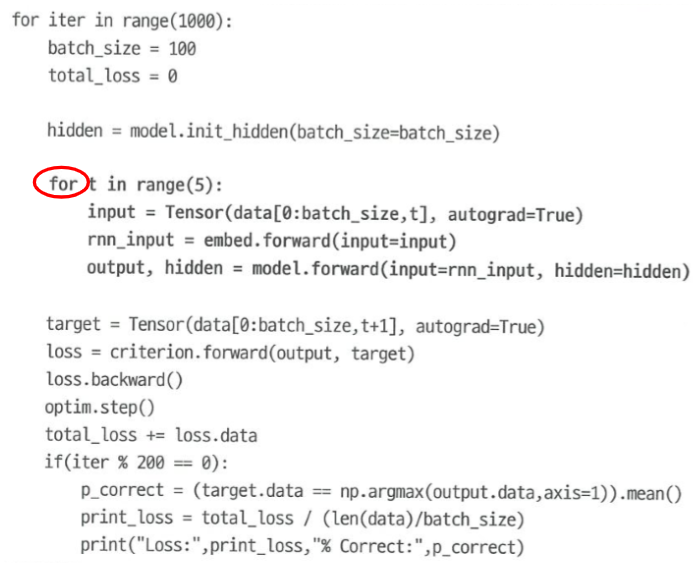

더 중요한 부분은 **역전파 단계**! 입력 데이터에 도달할 때까지 경사도를 계속해서 역전파하며 이 과정을 통해서 신경망은 모든 가중치에 대해 수정하고 전체 입력 예쩨에 대해 정확하게 예측하는 방법을 학습할 수 있었다. 위 코드에서는 입력 예제에 대해 순전파를 시행한 후, `loss.backward()`를 이용해 입력 데이터까지 경사도를 역전파 한다. 이가 가능한 이유는 동시에 많은 입력 데이터 요소를 넣어주지 않기 때문이다.(앞선 예제에서는 5개 정도 사용)

하지만 이번에 사용할 데이터는 숫자가 너무 많아 역전파가 어렵다. 그렇기 때문에 부분 역전파(truncated backpropagation)를 시행하는데 이는 고정된 단계만큼만 역전파하고 멈추는 것이다. 얼마나 역전파를 할지를 나타내는 길이 or 하나의 조정 가능한 매개변수로서 역할을 한다.

# **부분 역전파**

- 기술적으로 부분 역전파는 신경망을 악화시킵니다.

> 부분 역전파의 단점
>
>첫번째 : 신경망이 무언가를 기억하기 위해 학습할 수 있는 거리를 줄인다. 
>
>- RNN 은닉 계측 안에 우연히 설정해 둔 타음시탬프 보다 이전에 생긴 잔여 정보가 있을 수 있지만 이전에 정보에 대해서는 유지하도록 모델을 만들기 때문에 경사도를 사용할 수 없다. 그렇기 때문에 설정된 타임스탬프보다 많은 입력 신호에 대한 예측은 학습할 수 없다.
>
> - 언어 모델링에 대한 **절단 변수**는 **bptt**라고 이름 지었으며 이 변수의 값은 대개 16에서 64 사이의 크기로 설정한다.
>
>아래 코드 : 단어 갯수를 16개로 설정

In [0]:
batch_size = 16
bptt = 25
n_batches = int((indices.shape[0] / (batch_size)))

> 부분 역전파의 단점
>
>두번째 : 미니 배치 논리를 복잡하게 만든다.
> 
> - 부분 역전파를 사용하기 위해서는 커다란 데이터셋 하나가 아닌, `bptt` 크기의 작은 데이터셋 여러 개를 가지고 있다고 생각해야 하기 때문에 데이터셋을 묶어주는 작업이 필요하다.

In [0]:
#데이터셋에 bptt 적용하기

#--- 1번째 ---#
#데이터셋을 batch_size와 n_batches 간의 배수로 만들어 줌
#텐서로 그룹화해서 넣을 때 데이터 셋이 정방형이 됨.
trimmed_indices = indices[:n_batches*batch_size]

#--- 2번째 ---#
#데이터셋의 모양의바꿔 각 역이 초기 indices 배열의 일부가 되도록 만들어 주는 과정
batched_indices = trimmed_indices.reshape(batch_size, n_batches).transpose()

input_batched_indices = batched_indices[0:-1]
target_batched_indices = batched_indices[1:]

n_bptt = int(((n_batches-1) / bptt))
input_batches = input_batched_indices[:n_bptt*bptt].reshape(n_bptt,bptt,batch_size)
target_batches = target_batched_indices[:n_bptt*bptt].reshape(n_bptt, bptt, batch_size)
min_loss = 1000

In [24]:
batch_size = 8

print(raw[0:5])

That,


In [25]:
print(indices[0:5])

[48 10 13 40 51]


In [26]:
print(batched_indices[0:5])

[[48  4  8 46 11  8 32 52 22 30 48 44 52  9 52 40]
 [10 53 11 20 49 11 20 52 40 11 43 11 52 11 11 10]
 [13 48 49 40  8 40 45 11 11 10 58  8 11 40 46 50]
 [40  3  3 53 52 10 40 13  3 13 24 38 10 10  8  4]
 [51 12 52 12 52  3  8 52 40 38  4  8  3  8 29  4]]


`batch_size`를 8로 지정해줬기 때문에 열 개수가 8개이다. 이제 이 텐서는 각 길이가 `bptt`인 **소형 데이터셋의 리스트를 구축**하는 데에 사용된다.

In [0]:
#입력과 목표가 어떻게 구성되어있는지 print
input_batched_indices = batched_indices[0:-1]
target_batched_indices = batched_indices[1:]

In [28]:
#첫번째 줄부터 5번째 줄까지
print(input_batches[0][0:5])

[[48  4  8 46 11  8 32 52 22 30 48 44 52  9 52 40]
 [10 53 11 20 49 11 20 52 40 11 43 11 52 11 11 10]
 [13 48 49 40  8 40 45 11 11 10 58  8 11 40 46 50]
 [40  3  3 53 52 10 40 13  3 13 24 38 10 10  8  4]
 [51 12 52 12 52  3  8 52 40 38  4  8  3  8 29  4]]


In [29]:
#두번째부터 그 뒤의 5개의 줄을 출력
print(target_batches[0][0:5])

[[10 53 11 20 49 11 20 52 40 11 43 11 52 11 11 10]
 [13 48 49 40  8 40 45 11 11 10 58  8 11 40 46 50]
 [40  3  3 53 52 10 40 13  3 13 24 38 10 10  8  4]
 [51 12 52 12 52  3  8 52 40 38  4  8  3  8 29  4]
 [11 11 52 11 51 18 45 52 11  8 60 45 31 31 11 26]]


- 부분 역전파를 이용해서 반복하는 방법을 살펴봅시다.

> 이전 코드와 차이점은 **batch_loss**를 생성한다는 것!
> 
> 매 bptt 단계 후에, 역전파를 수행하고 가중치를 갱신한다. 그 후에는 앞에서와 동일하게 각 에폭마다 리셋되는 은닉 상태를 이용해서 계속 데이터셋을 읽는다.

In [0]:
def train(iterations=100):
    for iter in range(iterations):
        total_loss = 0
        n_loss = 0

        hidden = model.init_hidden(batch_size=batch_size)
        for batch_i in range(batches_to_train):

            hidden = (Tensor(hidden.data, autograd=True)
            loss = None
            losses = list()
            for t in range(bptt):
                input = Tensor(input_batches[batch_i][t], autograd=True)
                rnn_input = embed.forward(input=input)
                output, hidden = model.forward(input=rnn_input, hidden=hidden)

                target = Tensor(target_batches[batch_i][t], autograd=True)    
                batch_loss = criterion.forward(output, target)
                loss.append(batch_loss)
                if(t == 0):
                    loss = batch_size
                else:
                    loss = loss + batch_size

            for loss in losses:
              ""
            loss.backward()

            optim.step()
            total_loss += loss.data / bptt
            #출력단 설정
            log = "\r Iter:" + str(iter)
            log += " - Alpha:" + str(optim.alpha)[0:5]
            log += " - Batch "+str(batch_i+1)+"/"+str(len(input_batches))
            log += " - Min Loss:" + str(min_loss)[0:5]
            log += " - Loss:" + str(epoch_loss)
            if(batch_i == 0):
                log += " - " + generate_sample(n=70,'\n').replace("\n"," ")
            if(batch_i % 10 == 0 or batch_i-1 == len(input_batches)):
                sys.stdout.write(log)
        optim.alpha *= 0.99
        print()
train()